In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error
import scoringrules as sr
from properscoring import crps_ensemble
from typing import List, Tuple, Dict, Any
import json

## Carregamento dos Dados

In [2]:
# Configurações de plotagem
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Carregamento e transformações iniciais
df = pd.read_csv('data.csv')
df['week'] = pd.to_datetime(df['week'])
df = df.set_index('week').sort_index()

# Transformações para estabilizar variância e remover tendência
df['log_volume'] = np.log(df['volume'])
df['dlog_volume'] = df['log_volume'].diff()

# Divisão em treino e teste (80/20)
test_size = 52 # Conforme o relatório, o horizonte de teste é de 52 semanas
train = df.iloc[:-test_size].copy()
test = df.iloc[-test_size:].copy()

print("Dados Carregados e Preparados.")
print(f"Período de Treino: {train.index.min().date()} a {train.index.max().date()}")
print(f"Período de Teste:  {test.index.min().date()} a {test.index.max().date()}")

# Exibindo o final da série de treino
train.tail()

Dados Carregados e Preparados.
Período de Treino: 2022-10-31 a 2024-09-09
Período de Teste:  2024-09-16 a 2025-09-08


,volume,log_volume,dlog_volume
week,,,
2024-08-12,7.74,2.046402,0.194802
2024-08-19,6.99,1.944481,-0.101921
2024-08-26,5.04,1.617406,-0.327074
2024-09-02,4.11,1.413423,-0.203983
2024-09-09,4.85,1.578979,0.165556


# Entendendo o dataset

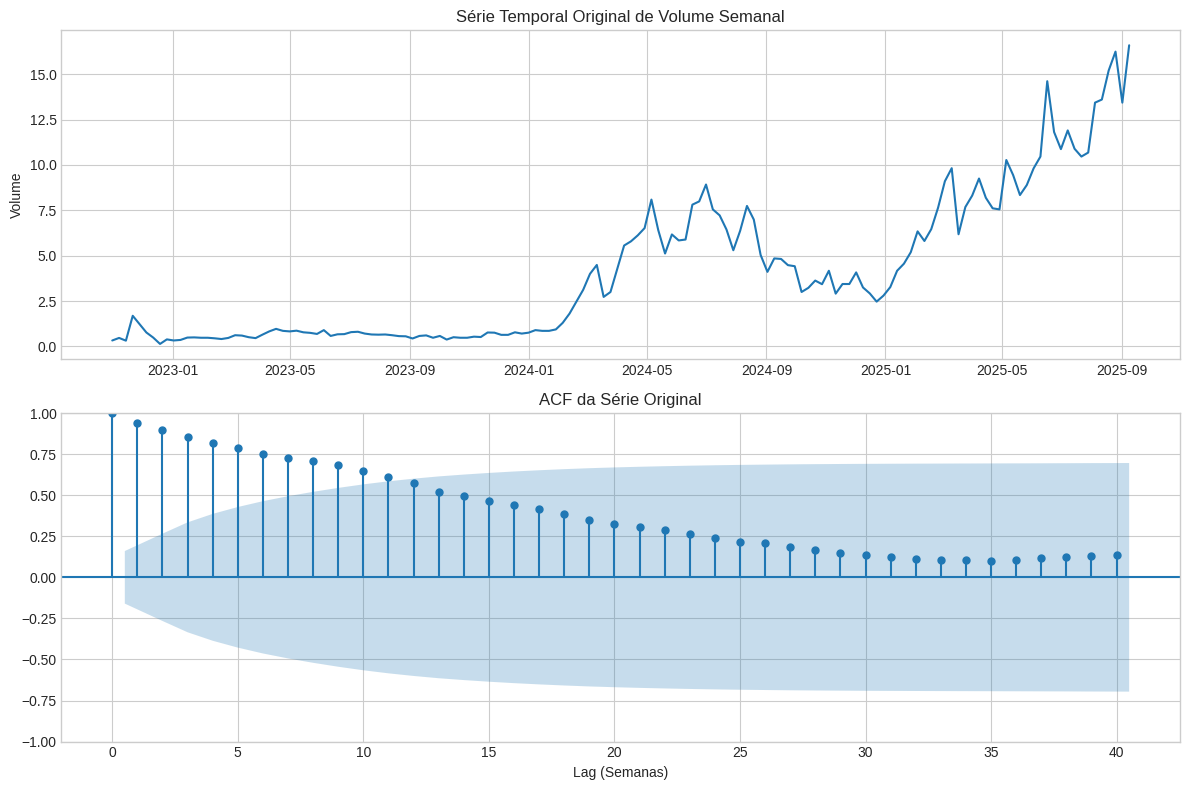

In [3]:
# --- Análise Visual da Série Original e seu ACF ---

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot da série original 'volume'
ax1.plot(df.index, df['volume'], label='Volume Original')
ax1.set_title('Série Temporal Original de Volume Semanal')
ax1.set_ylabel('Volume')

# Plot do ACF da série original
plot_acf(df['volume'].dropna(), ax=ax2, lags=40) # Aumentando os lags para ver o decaimento
ax2.set_title('ACF da Série Original')
ax2.set_xlabel('Lag (Semanas)')

plt.tight_layout()
plt.show()

Conclusão: O gráfico da série mostra uma clara tendência de crescimento e um aumento na variabilidade ao longo do tempo (heterocedasticidade)

O ACF confirma isso com autocorrelações que permanecem altas (próximas de 1) e decaem muito lentamente, um sinal clássico de não-estacionariedade

In [4]:
# --- Análise de Sazonalidade e Tendência com STL ---
print("Analisando a força da Sazonalidade e Tendência...")

def seasonal_strength(trend, seasonal, resid):
    var = np.nanvar
    Fs = max(0.0, 1.0 - var(resid) / var(seasonal + resid))
    Ft = max(0.0, 1.0 - var(resid) / var(trend + resid))
    return float(Ft), float(Fs)

candidatos_saz = [4, 13, 26, 52] # Períodos em semanas (mensal, trimestral, semestral, anual)
results = []
for m in candidatos_saz:
    res = STL(df['volume'].dropna(), period=m, robust=True).fit()
    Ft, Fs = seasonal_strength(res.trend, res.seasonal, res.resid)
    results.append({"Período (m)": m, "Força da Tendência (Ft)": Ft, "Força da Sazonalidade (Fs)": Fs})

stl_results_df = pd.DataFrame(results).sort_values("Força da Sazonalidade (Fs)", ascending=False)
display(stl_results_df)

Analisando a força da Sazonalidade e Tendência...


,Período (m),Força da Tendência (Ft),Força da Sazonalidade (Fs)
3,52,0.934493,0.841772
2,26,0.850949,0.066135
1,13,0.922627,0.000000
0,4,0.961441,0.000000


Conclusão da Análise STL: 

A Força da Tendência (Ft > 0.9) é extremamente alta, confirmando a tendência visual.

A Força da Sazonalidade em m=52 é alta, indicando que há uma sazonalidade a cada 52 semanas (ano em ano)

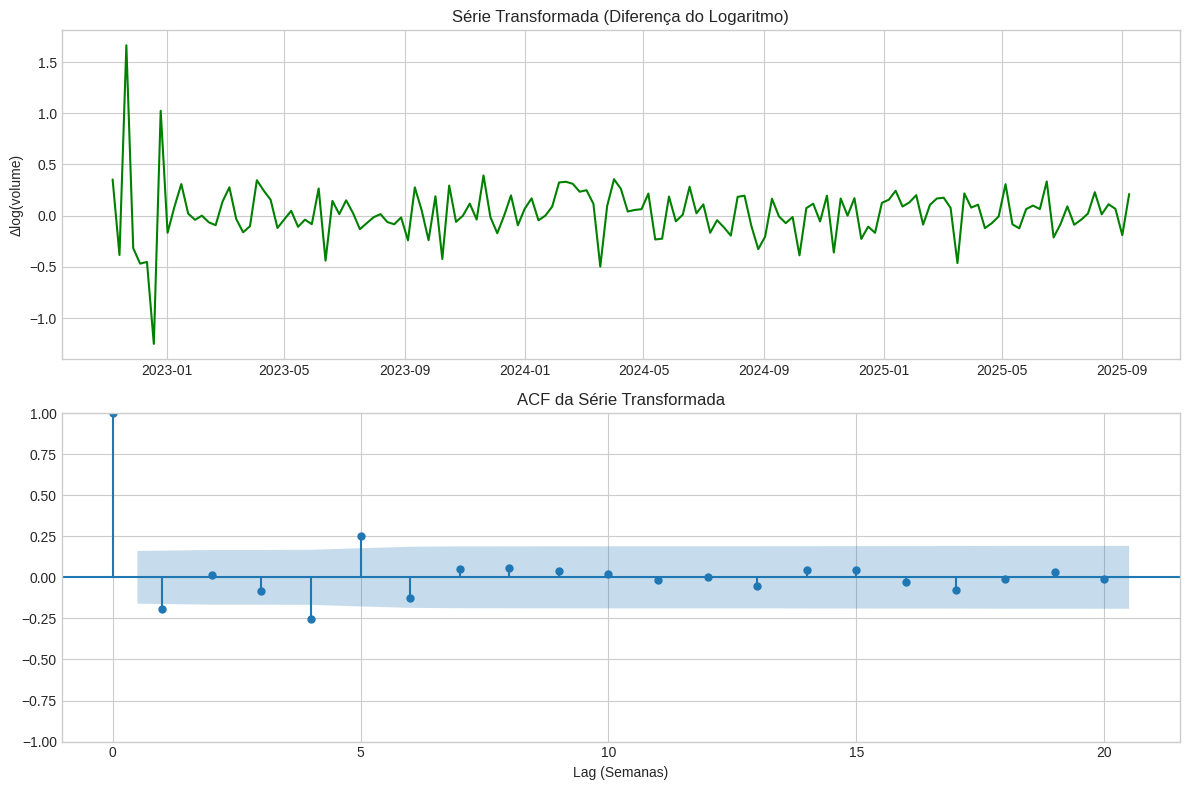

In [5]:
# --- Verificação da Estacionariedade após Transformações ---

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot da série transformada dlog_volume
ax1.plot(df.index, df['dlog_volume'], label='Δlog(volume)', color='green')
ax1.set_title('Série Transformada (Diferença do Logaritmo)')
ax1.set_ylabel('Δlog(volume)')

# Plot do ACF da série transformada
plot_acf(df['dlog_volume'].dropna(), ax=ax2, lags=20)
ax2.set_title('ACF da Série Transformada')
ax2.set_xlabel('Lag (Semanas)')

plt.tight_layout()
plt.show()

Conclusão: Após as transformações, a série aparenta ser estacionária, sem tendência e com autocorrelações que decaem rapidamente para dentro do intervalo de confiança.

## Baselines

### Métricas de avaliação

In [6]:
from scipy.stats import lognorm
import scoringrules as sr

def calculate_all_metrics(y_true, y_pred, train_true, mu_log, sigma_log):
    metrics = {}

    metrics['MAE'] = mean_absolute_error(y_true, y_pred)
    metrics['MSE'] = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(metrics['MSE'])

    in_sample_naive_error = train_true.diff(1).dropna()
    scale_mae = np.mean(np.abs(in_sample_naive_error))
    scale_rmse = np.sqrt(np.mean(np.square(in_sample_naive_error)))
    metrics['MASE'] = metrics['MAE'] / scale_mae if scale_mae != 0 else np.inf
    metrics['RMSSE'] = rmse / scale_rmse if scale_rmse != 0 else np.inf

    dist_params = {"s": sigma_log, "scale": np.exp(mu_log)}

    try:
        n_samples = 1000
        ensemble_forecasts = lognorm.rvs(s=sigma_log, scale=np.exp(mu_log), size=(n_samples, len(y_true))).T
        crps_scores = sr.crps_ensemble(y_true.values, ensemble_forecasts)
        metrics['CRPS'] = np.mean(crps_scores)
    except AttributeError:
        print("Aviso: 'crps_ensemble' não encontrado em 'scoringrules'. A métrica CRPS será ignorada.")
        metrics['CRPS'] = np.nan
    except Exception as e:
        print(f"Ocorreu um erro ao calcular o CRPS: {e}")
        metrics['CRPS'] = np.nan

    quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
    avg_quantile_loss = 0
    for q in quantiles:
        pred_q = lognorm.ppf(q, **dist_params)
        errors = y_true - pred_q
        q_loss = np.mean(np.maximum(q * errors, (q - 1) * errors))
        metrics[f'QL_q{int(q*100)}'] = q_loss
        avg_quantile_loss += q_loss
    metrics['AvgQL'] = avg_quantile_loss / len(quantiles)

    alpha = 0.10
    lower_bound = lognorm.ppf(alpha / 2, **dist_params)
    upper_bound = lognorm.ppf(1 - alpha / 2, **dist_params)
    interval_width = upper_bound - lower_bound
    lower_penalty = np.where(y_true < lower_bound, (lower_bound - y_true) * (2 / alpha), 0)
    upper_penalty = np.where(y_true > upper_bound, (y_true - upper_bound) * (2 / alpha), 0)
    winkler_scores = interval_width + lower_penalty + upper_penalty
    metrics['Winkler90'] = np.mean(winkler_scores)
    
    return metrics

### Modelos

In [7]:
def mean_model(train_series, h):
    prediction = np.full(h, train_series.mean())
    in_sample_preds = train_series.shift(0).fillna(train_series.mean())
    return prediction, in_sample_preds

def naive_model(train_series, h):
    prediction = np.full(h, train_series.iloc[-1])
    in_sample_preds = train_series.shift(1)
    return prediction, in_sample_preds

def seasonal_naive_model(train_series, h, m=52):
    # A análise STL mostrou m=52 como o período sazonal mais forte
    last_season = train_series.iloc[-m:]
    prediction = np.tile(last_season.values, (h // m) + 1)[:h]
    in_sample_preds = train_series.shift(m)
    return prediction, in_sample_preds

def drift_model(train_series, h):
    T = len(train_series)
    drift = (train_series.iloc[-1] - train_series.iloc[0]) / (T - 1)
    prediction = train_series.iloc[-1] + np.arange(1, h + 1) * drift
    in_sample_preds = train_series.shift(1) + drift
    return prediction, in_sample_preds

# --- 3.3 Execução e Avaliação dos Baselines ---
models = {
    "Média": mean_model, "Naive": naive_model,
    "Naive Sazonal": seasonal_naive_model, "Drift": drift_model
}

In [8]:
results_list = []
predictions_dict = {}
residuals = {}

print("Avaliando os modelos de referência...")
for name, model_func in models.items():
    # 1. Obter previsões e resíduos no espaço do log
    log_preds, log_in_sample_preds = model_func(train['log_volume'], test_size)
    log_residuals = (train['log_volume'] - log_in_sample_preds).dropna()
    sigma = np.std(log_residuals) # Desvio padrão dos resíduos para métricas distribucionais
    
    # 2. Reverter previsões pontuais para a escala original
    predictions = np.exp(log_preds)
    predictions_dict[name] = pd.Series(predictions, index=test.index)
    
    # 3. Calcular todas as métricas
    model_metrics = calculate_all_metrics(
        y_true=test['volume'], y_pred=predictions, train_true=train['volume'],
        mu_log=log_preds, sigma_log=sigma
    )
    model_metrics['Modelo'] = name
    results_list.append(model_metrics)
    residuals[name] = log_residuals
    print(f"  - Modelo '{name}' avaliado.")

# --- 3.4 Apresentação dos Resultados ---
baseline_results_df = pd.DataFrame(results_list).set_index('Modelo')
pd.set_option('display.float_format', '{:.4f}'.format)

print("\n--- Resultados de Acurácia dos Baselines (Out-of-Sample) ---")
display(baseline_results_df[['MASE', 'RMSSE', 'CRPS', 'AvgQL', 'Winkler90']])

Avaliando os modelos de referência...
Ocorreu um erro ao calcular o CRPS: Domain error in arguments. The `scale` parameter must be positive for all distributions, and many distributions have restrictions on shape parameters. Please see the `scipy.stats.lognorm` documentation for details.
  - Modelo 'Média' avaliado.
  - Modelo 'Naive' avaliado.
  - Modelo 'Naive Sazonal' avaliado.
  - Modelo 'Drift' avaliado.

--- Resultados de Acurácia dos Baselines (Out-of-Sample) ---


,MASE,RMSSE,CRPS,AvgQL,Winkler90
Modelo,,,,,
Média,17.2960,12.1818,NaN,NaN,NaN
Naive,10.0159,7.7907,3.0155,1.3905,35.3553
Naive Sazonal,10.8678,7.4129,2.7729,1.2251,22.3804
Drift,8.7874,5.8390,2.2815,0.9949,15.7826


Conclusão: O modelo de Drift apresenta a melhor performance na maioria das métricas pontuais e distribucionais, confirmando que a tendência é o principal driver da série.


In [9]:
print("\nDiagnóstico dos Resíduos dos Baselines:")

ljung_box_mean = acorr_ljungbox(residuals['Média'], lags=[10], return_df=True)
ljung_box_naive = acorr_ljungbox(residuals['Naive'], lags=[10], return_df=True)
ljung_box_naive_seasonal = acorr_ljungbox(residuals['Naive Sazonal'], lags=[10], return_df=True)
ljung_box_drift = acorr_ljungbox(residuals['Drift'], lags=[10], return_df=True)
acorrs = {
    "Média": ljung_box_mean,
    "Naive": ljung_box_naive,
    "Naive Sazonal": ljung_box_naive_seasonal,
    "Drift": ljung_box_drift
}
# Make a PD series with all of them

acorrs_df = pd.concat(acorrs, axis=0)
display(acorrs_df)


Diagnóstico dos Resíduos dos Baselines:


/home/luusamp/gits/series_temporais/venv/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


,,lb_stat,lb_pvalue
Média,10,NaN,NaN
Naive,10,24.4518,0.0065
Naive Sazonal,10,175.3779,0.0000
Drift,10,24.4518,0.0065


/home/luusamp/gits/series_temporais/venv/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


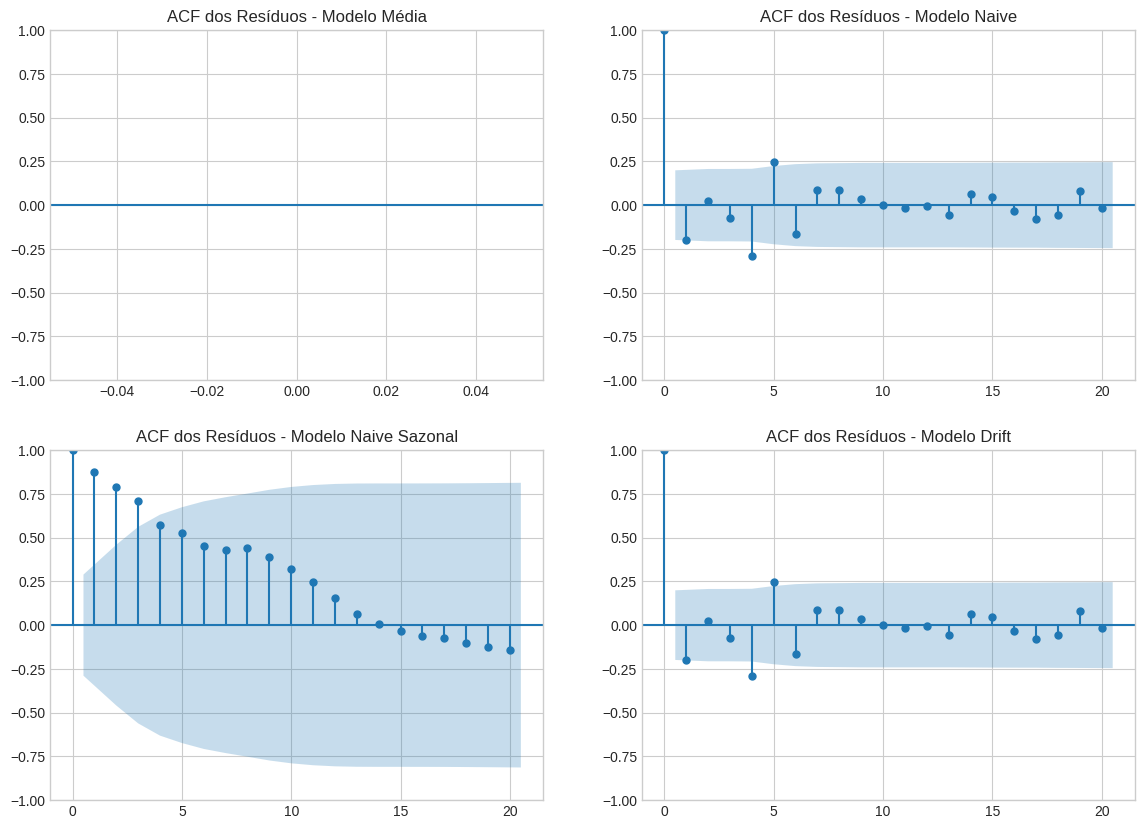

In [10]:
# ACF dos resíduos dos baselines

fig, ax = plt.subplots(2, 2, figsize=(14, 10))
for i, (name, resids) in enumerate(residuals.items()):
    plot_acf(resids, ax=ax[i//2, i%2], lags=20)
    ax[i//2, i%2].set_title(f'ACF dos Resíduos - Modelo {name}')

Conclusão: O p-valor baixo no teste de Ljung-Box e os picos no ACF indicam que os resíduos dos baselines, inclusive do Drift (nosso melhor em outras métricas) AINDA possuem autocorrelação, principalmente nos lags 4 e 5. Precisamos de um modelo que captura essa dependência.

# Modelos de Regressão Linear Múltipla

In [11]:
OUTDIR = Path("mlr_results")
OUTDIR.mkdir(parents=True, exist_ok=True)

def load_series(path: Path) -> pd.DataFrame:
    """
    Carrega a série em um pandas.DataFrame

    Parâmetros
    ----------
    path : Path
        Caminho do arquivo.

    Retorna
    -------
    pd.DataFrame
        DataFrame contendo os dados originais com colunas adicionais transformadas.
    """
    df = pd.read_csv(path)
    df["week_dt"] = pd.to_datetime(df["week"])
    df = df.sort_values("week_dt").reset_index(drop=True)
    df["volume"] = df["volume"].astype(float)
    df["log_volume"] = np.log(df["volume"])
    df["dlog_volume"] = df["log_volume"].diff()
    return df.dropna().reset_index(drop=True)


def choose_period_stl(ts: pd.Series, candidates: List[int]) -> Tuple[int, pd.DataFrame]:
    """
    Escolhe o melhor período sazonal com base na decomposição STL (Seasonal–Trend decomposition using Loess).

    Parâmetros
    ----------
    ts : pd.Series
        Série temporal.
    candidates : List[int]
        Lista de períodos candidatos à sazonalidade.

    Retorna
    -------
    Tuple[int, pd.DataFrame]
        Tupla com o melhor período de sazonalidade e um DataFrame com as forças de tendência e sazonalidade
        calculadas para cada período.
    """
    rows = []
    for m in candidates:
        res = STL(ts, period=m, robust=True).fit()
        
        # Força da tendência
        Ft = max(0.0, 1.0 - np.var(res.resid) / np.var(res.trend + res.resid))
        
        # Força da sazonalidade
        Fs = max(0.0, 1.0 - np.var(res.resid) / np.var(res.seasonal + res.resid))
        rows.append({"period": m, "Ft": float(Ft), "Fs": float(Fs)})
        
    tab = pd.DataFrame(rows).sort_values("Fs", ascending=False).reset_index(drop=True)
    best = int(tab.loc[0, "period"])
    return best, tab


def add_stl_components(df: pd.DataFrame, period: int) -> pd.DataFrame:
    """
    Adiciona os componentes da decomposição STL (tendência, sazonalidade e diferença da tendência) ao DataFrame.
    
    Parâmetros
    ----------
    df : pd.DataFrame
        DataFrame de entrada.
    period : int
        Período sazonal.

    Retorna
    -------
    pd.DataFrame
        DataFrame com as seguintes colunas adicionais:
        - 'trend_stl': componente de tendência.
        - 'season_stl': componente sazonal.
        - 'dtrend_stl': primeira diferença da tendência.
        - 't': índice temporal como array float.
    """
    res = STL(df["volume"], period=period, robust=True).fit()
    out = df.copy()
    out["trend_stl"] = pd.Series(res.trend, index=out.index)
    out["season_stl"] = pd.Series(res.seasonal, index=out.index)
    out["dtrend_stl"] = out["trend_stl"].diff()
    out["t"] = np.arange(len(out), dtype=float)
    return out.dropna().reset_index(drop=True)


def design(y: pd.Series, Xcols: List[str], df: pd.DataFrame):
    """
    Prepara a variável resposta e a matriz de preditores para regressão linear múltipla.

    Parâmetros
    ----------
    y : pd.Series
        Nome da variável resposta (coluna alvo).
    Xcols : List[str]
        Lista de nomes das colunas a serem usadas como preditores.
    df : pd.DataFrame
        DataFrame contendo os dados.

    Retorna
    -------
    yv : np.ndarray
        Vetor com os valores da variável resposta.
    Xv : np.ndarray
        Matriz de preditores (incluindo intercepto).
    names : List[str]
        Lista com os nomes das colunas da matriz de preditores (inclui 'const').

    Observação
    ----------
    Se `Xcols` estiver vazia, a matriz conterá apenas o termo de intercepto.
    """
    yv = df[y].to_numpy(dtype=float)
    Xv = sm.add_constant(df[Xcols].to_numpy(dtype=float), has_constant="add") if Xcols else sm.add_constant(np.zeros((len(df),0)))
    names = ["const"] + Xcols
    return yv, Xv, names


def fit_ols(y: np.ndarray, X: np.ndarray):
    """
    Ajusta um modelo de regressão linear OLS (Ordinary Least Squares).

    Parâmetros
    ----------
    y : np.ndarray
        Variável dependente (valores alvo).
    X : np.ndarray
        Variáveis independentes (preditores).

    Retorna
    -------
    res : RegressionResults
        Objeto com os resultados do ajuste OLS.

    Observação
    ----------
    Linhas com valores ausentes em `y` ou `X` são removidas antes do ajuste.
    """
    model = sm.OLS(y, X, missing="drop")
    res = model.fit()
    return res


def loocv_mse(y: np.ndarray, X: np.ndarray, res) -> float:
    """
    Calcula o erro quadrático médio (MSE) da validação cruzada Leave-One-Out (LOOCV).

    Parâmetros
    ----------
    y : np.ndarray
        Valores reais da variável resposta.
    X : np.ndarray
        Matriz de preditores.
    res : object
        Resultado do modelo ajustado, com atributo `fittedvalues`.

    Retorna
    -------
    float
        Valor do MSE da validação cruzada LOOCV.

    Observação
    ----------
    O cálculo é feito de forma eficiente usando a diagonal da matriz hat,
    sem necessidade de refazer o ajuste n vezes.
    """
    XtX = X.T @ X
    XtX_inv = np.linalg.inv(XtX)
    H_diag = np.einsum('ij,jk,ik->i', X, XtX_inv, X)
    resid = y - res.fittedvalues
    return float(np.mean((resid / (1.0 - H_diag))**2))


def metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    """
    Calcula métricas de erro de regressão entre valores reais e previstos.

    Parâmetros
    ----------
    y_true : np.ndarray
        Valores reais.
    y_pred : np.ndarray
        Valores previstos.

    Retorna
    -------
    Dict[str, float]
        Dicionário com:
            - 'RMSE': Raiz do erro quadrático médio.
            - 'MAE': Erro absoluto médio.
    """
    mse = float(np.mean((y_true - y_pred) ** 2))
    rmse = float(np.sqrt(mse))
    mae = float(np.mean(np.abs(y_true - y_pred)))
    return {"RMSE": rmse, "MAE": mae}


def generate_prediction_samples(res, X, n_samples=20):
    """
    Gera amostras da distribuição de previsão para cada observação em X.

    Parâmetros
    ----------
    res : RegressionResults
        Resultados do modelo de regressão.
    X : np.ndarray
        Matriz de preditores.
    n_samples : int
        Número de amostras de previsão por observação.

    Retorna
    -------
    samples : List[List[float]]
        Lista de listas, onde cada sublista contém `n_samples` amostras para aquela previsão.
    """
    point_pred = res.predict(X)
    pred_results = res.get_prediction(X)
    var_pred = pred_results.var_pred
    var_total = res.mse_resid + var_pred
    std_total = np.sqrt(var_total)
    samples = []
    for i in range(len(X)):
        samp = np.random.normal(loc=point_pred[i], scale=std_total[i], size=n_samples)
        samples.append(samp.tolist())
    return samples


def make_payload_entry(name: str,
                       y_true: np.ndarray,
                       y_pred: np.ndarray,
                       samples: List[List[float]]) -> Dict[str, Any]:
    """
    Cria uma entrada de payload com os resultados do modelo.

    Parâmetros
    ----------
    name : str
        Nome do modelo.
    y_true : np.ndarray
        Valores reais.
    y_pred : np.ndarray
        Valores previstos.
    samples : List[List[float]]
        Amostras da distribuição de previsão.

    Retorna
    -------
    Dict[str, Any]
        Dicionário com os dados formatados para exportação ou visualização.
    """
    return {
        "nome_modelo": name,
        "y_true": [float(v) for v in y_true],
        "y_pred": [float(v) for v in y_pred],
        "y_dist": samples,  
    }


Ljungbox Results 
: {'M0_intercept':     lb_stat  lb_pvalue
10  24.9429     0.0055, 'M1_time_trend':     lb_stat  lb_pvalue
10  24.9840     0.0054, 'M2_stl':     lb_stat  lb_pvalue
10  23.6847     0.0085, 'M3_time_plus_stl':     lb_stat  lb_pvalue
10  23.7061     0.0084}


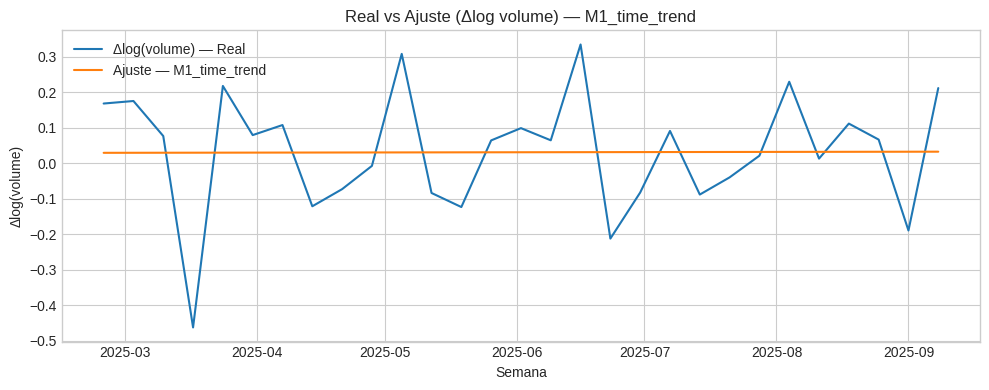

In [12]:
# ==========================================================
# 1) Carregamento e transformação inicial
# ==========================================================
raw_data = load_series(Path("data.csv"))

# ==========================================================
# 2) Escolha do melhor período sazonal usando decomposição STL
# ==========================================================
seasonal_period_candidates = [4, 5, 13, 26, 52, 53]
best_period, stl_results_table = choose_period_stl(raw_data["volume"], seasonal_period_candidates)

# ==========================================================
# 3) Adição dos componentes de tendência e sazonalidade (STL)
# ==========================================================
data = add_stl_components(raw_data, best_period)

# ==========================================================
# 4) Divisão temporal dos dados: 80% treino / 20% teste
# ==========================================================
n_obs = len(data)
n_test = max(1, int(np.floor(0.2 * n_obs)))

train_data = data.iloc[:-n_test].copy()
test_data = data.iloc[-n_test:].copy()

# ==========================================================
# 5) Especificação dos modelos testados (intercepto, tendência, STL, combinado)
# ==========================================================
models = {
    "M0_intercept": [],
    "M1_time_trend": ["t"],
    "M2_stl": ["dtrend_stl", "season_stl"],
    "M3_time_plus_stl": ["t", "dtrend_stl", "season_stl"],
}

metrics_list = []
coef_tables = {}
test_predictions = test_data[["week_dt", "dlog_volume"]].copy()
ljungbox_results = {}

for model_name, features in models.items():
    # Treinamento do modelo
    y_train, X_train, feature_names = design("dlog_volume", features, train_data)
    model_fit = fit_ols(y_train, X_train)

    # Teste do modelo
    y_test, X_test, _ = design("dlog_volume", features, test_data)
    yhat_train = model_fit.predict(X_train)
    yhat_test = model_fit.predict(X_test)

    # Cálculo das métricas
    train_metrics = metrics(y_train, yhat_train)
    test_metrics = metrics(y_test, yhat_test)

    r2_adj = float(model_fit.rsquared_adj)
    loocv_error = loocv_mse(y_train, X_train, model_fit)
    aic_val, bic_val = float(model_fit.aic), float(model_fit.bic)

    metrics_list.append([
        model_name, r2_adj, loocv_error, aic_val, bic_val,
        train_metrics["RMSE"], train_metrics["MAE"],
        test_metrics["RMSE"], test_metrics["MAE"]
    ])

    # Tabela de coeficientes
    coef_df = pd.DataFrame({
        "variable": feature_names,
        "coefficient": model_fit.params,
        "p_value": model_fit.pvalues
    })
    coef_tables[model_name] = coef_df

    # Predições e teste de autocorrelação (Ljung-Box)
    test_predictions[f"yhat_{model_name}"] = yhat_test
    ljungbox_results[model_name] = acorr_ljungbox(model_fit.resid, lags=[10], return_df=True)

# ==========================================================
# 6) Testes F para comparação de modelos aninhados (significância conjunta)
# ==========================================================
fit_M0 = fit_ols(*design("dlog_volume", models["M0_intercept"], train_data)[:2])
fit_M1 = fit_ols(*design("dlog_volume", models["M1_time_trend"], train_data)[:2])
fit_M2 = fit_ols(*design("dlog_volume", models["M2_stl"], train_data)[:2])
fit_M3 = fit_ols(*design("dlog_volume", models["M3_time_plus_stl"], train_data)[:2])

print("Ljungbox Results \n:", ljungbox_results)

f_test_results = {
    "time_trend_vs_intercept": {
        "F": float(fit_M1.compare_f_test(fit_M0)[0]),
        "p_value": float(fit_M1.compare_f_test(fit_M0)[1]),
        "df_diff": int(fit_M1.compare_f_test(fit_M0)[2]),
    },
    "stl_vs_intercept": {
        "F": float(fit_M2.compare_f_test(fit_M0)[0]),
        "p_value": float(fit_M2.compare_f_test(fit_M0)[1]),
        "df_diff": int(fit_M2.compare_f_test(fit_M0)[2]),
    },
    "time_plus_stl_vs_stl": {
        "F": float(fit_M3.compare_f_test(fit_M2)[0]),
        "p_value": float(fit_M3.compare_f_test(fit_M2)[1]),
        "df_diff": int(fit_M3.compare_f_test(fit_M2)[2]),
    },
}

# ==========================================================
# 7) Salvamento dos coeficientes, métricas e resultados de teste
# ==========================================================
coef_paths = {}
for model_name, table in coef_tables.items():
    path = OUTDIR / f"{model_name}_coefficients_stl.csv"
    table.to_csv(path, index=False)
    coef_paths[model_name] = str(path)

# Predições e tabela de busca de período sazonal
predictions_path = OUTDIR / "test_predictions.csv"
test_predictions.to_csv(predictions_path, index=False)

stl_search_path = OUTDIR / "stl_period_search.csv"
stl_results_table.to_csv(stl_search_path, index=False)

# Testes F
with open(OUTDIR / "f_tests_stl.json", "w", encoding="utf-8") as f:
    json.dump(f_test_results, f, indent=2)

# Consolidação das métricas
metrics_df = pd.DataFrame(
    metrics_list,
    columns=[
        "model", "R2_adj", "LOOCV_MSE", "AIC", "BIC",
        "train_RMSE", "train_MAE", "test_RMSE", "test_MAE"
    ]
)
metrics_path = OUTDIR / "ts_regression_metrics_stl.csv"
metrics_df.to_csv(metrics_path, index=False)

# ==========================================================
# 8) Geração do gráfico do melhor modelo (menor RMSE no teste)
# ==========================================================
best_model_name = min(
    models.keys(),
    key=lambda name: metrics_df.loc[metrics_df["model"] == name, "test_RMSE"].values[0]
)

_, X_test_best, _ = design("dlog_volume", models[best_model_name], test_data)
yhat_best = fit_ols(*design("dlog_volume", models[best_model_name], train_data)[:2]).predict(X_test_best)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(test_data["week_dt"], test_data["dlog_volume"], label="Δlog(volume) — Real")
ax.plot(test_data["week_dt"], yhat_best, label=f"Ajuste — {best_model_name}")
ax.set_title(f"Real vs Ajuste (Δlog volume) — {best_model_name}")
ax.set_xlabel("Semana")
ax.set_ylabel("Δlog(volume)")
ax.legend()
plt.tight_layout()

plot_path = OUTDIR / f"{best_model_name}_test_fit.png"
plt.savefig(plot_path, dpi=150)

# ==========================================================
# 9) Reajuste do melhor modelo e geração de amostras (IC 95%)
# ==========================================================
best_model_fit = fit_ols(*design("dlog_volume", models[best_model_name], train_data)[:2])
X_train_best = design("dlog_volume", models[best_model_name], train_data)[1]
X_test_best = design("dlog_volume", models[best_model_name], test_data)[1]

n_samples = 50
train_samples = generate_prediction_samples(best_model_fit, X_train_best, n_samples)
test_samples = generate_prediction_samples(best_model_fit, X_test_best, n_samples)

y_train_true = train_data["dlog_volume"].to_numpy()
y_test_true = test_data["dlog_volume"].to_numpy()

# ==========================================================
# 10) Criação dos payloads finais (intervalos de confiança de 95%)
# ==========================================================
model_name_readable = (
    "Intercept Model" if best_model_name == "M0_intercept" else f"Model {best_model_name}"
)

train_payload = make_payload_entry(
    name=f"{model_name_readable} (train)",
    y_true=y_train_true,
    y_pred=best_model_fit.predict(X_train_best),
    samples=train_samples,
)

test_payload = make_payload_entry(
    name=f"{model_name_readable} (test)",
    y_true=y_test_true,
    y_pred=best_model_fit.predict(X_test_best),
    samples=test_samples,
)

# Salvando os dados do melhor modelo de regressão múltipla
train_results_lr = [train_payload]
test_results_lr = [test_payload]

# Modelagem

### O modelo simples M0

Ajustando e diagnosticando o modelo de regressão simples M0 (Intercepto)...

Teste de Ljung-Box (M0):


,lb_stat,lb_pvalue
10,24.4518,0.0036


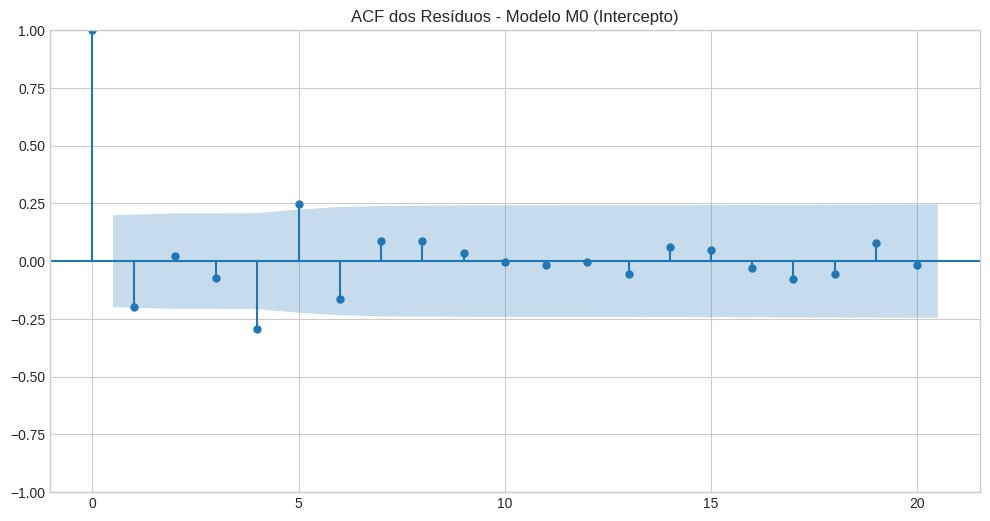

In [13]:
print("Ajustando e diagnosticando o modelo de regressão simples M0 (Intercepto)...")
y_train = train['dlog_volume'].dropna()
X_train = sm.add_constant(np.zeros(len(y_train)))

model_M0 = sm.OLS(y_train, X_train).fit()
residuals_M0 = model_M0.resid

# Teste de Ljung-Box e ACF para M0
ljung_box_M0 = acorr_ljungbox(residuals_M0, lags=[10], model_df=1, return_df=True)
print("\nTeste de Ljung-Box (M0):")
display(ljung_box_M0)

fig, ax = plt.subplots()
plot_acf(residuals_M0, ax=ax, lags=20)
ax.set_title('ACF dos Resíduos - Modelo M0 (Intercepto)')
plt.show()

Conclusão: Assim como no Drift, os resíduos do M0 apresentam forte autocorrelação nos lags 4 e 5. Precisamos adicionar esses termos ao modelo.



Construindo e validando o modelo Auto-Regressivo M_AR...

Teste de Ljung-Box (M_AR):


,lb_stat,lb_pvalue
10,9.5091,0.2181


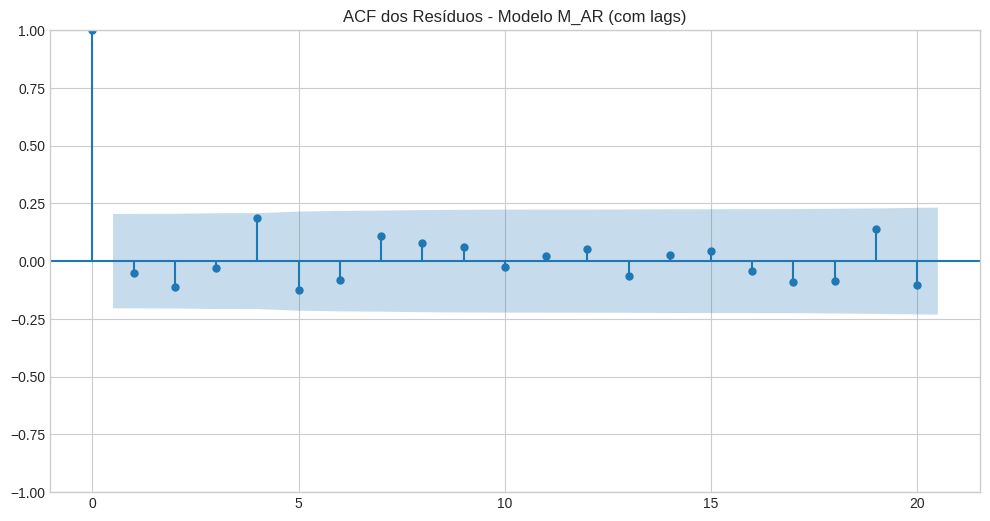

In [14]:
print("\nConstruindo e validando o modelo Auto-Regressivo M_AR...")
train_ar = train.copy()
train_ar['dlog_volume_lag4'] = train_ar['dlog_volume'].shift(4)
train_ar['dlog_volume_lag5'] = train_ar['dlog_volume'].shift(5)
train_ar = train_ar.dropna()

# Ajuste do novo modelo com os lags
y_train_ar = train_ar['dlog_volume']
X_train_ar = sm.add_constant(train_ar[['dlog_volume_lag4', 'dlog_volume_lag5']])

model_AR = sm.OLS(y_train_ar, X_train_ar).fit()
residuals_AR = model_AR.resid

# Teste de Ljung-Box e ACF para o novo modelo
ljung_box_AR = acorr_ljungbox(residuals_AR, lags=[10], model_df=3, return_df=True) # 1 intercepto + 2 lags = 3 parâmetros
print("\nTeste de Ljung-Box (M_AR):")
display(ljung_box_AR)

fig, ax = plt.subplots()
plot_acf(residuals_AR, ax=ax, lags=20)
ax.set_title('ACF dos Resíduos - Modelo M_AR (com lags)')
plt.show()

# display(model_AR.summary())

Conclusão Final: O p-valor alto no teste de Ljung-Box e o ACF sem picos significativos indicam que os resíduos do modelo M_AR se comportam como ruído branco. Este é o nosso modelo final.

# Comparação

### Avaliação dos Erros

1. **Transformação para a escala original**  
   Inicialmente, transformamos a predição de volta para a escala original dos dados:  
   
   $\hat{y} = \exp(y_{\text{log}})$

2. **Cálculo dos resíduos**  
   A partir de \(\hat{y}\), obtemos os resíduos e erros no instante \(t\) (tanto no treino quanto no teste):  
   
   $e_t = y_t - \hat{y}_t$

3. **Cálculo das métricas**  
   Com os resíduos, podemos calcular as métricas de avaliação dos erros do modelo.

---

### Escolha das Métricas para previsão pontual

Optamos por utilizar **erros escalados**, pois eles permitem comparar o desempenho do modelo em relação a um benchmark básico. Além disso, esse tipo de métrica pode ser útil em trabalhos futuros.  

As métricas selecionadas foram:  
- **Erro Absoluto Médio Escalado (MASE)**  
- **Raiz do Erro Quadrático Médio Escalado (RMSSE)** 

### Escolha de Métricas para previsão distribucional
Com a finalidade de medir outras características dos modelos além de previsões pontuais, selecionamos as demais métricas para quantificar a distribuição das saídas

- **Wrinkler Score:** Avaliação dos intervalos de predição.
- **Continuous Ranked Probability Score (CRPS):** Avaliação da distribuição preditiva como um todo.

--- Tabela de Comparação Final ---


,MAE,MSE,MASE,RMSSE,CRPS,QL_q5,QL_q25,QL_q50,QL_q75,QL_q95,AvgQL,Winkler90
Modelo Drift (Baseline),3.3012,13.2491,8.7874,5.8390,2.3048,0.2590,1.0709,1.6506,1.4637,0.5301,0.9949,15.7826
Modelo AR (Final),1.9159,5.1836,5.0999,3.6522,1.4677,0.4271,0.8653,0.9579,0.7717,0.2856,0.6615,14.2534


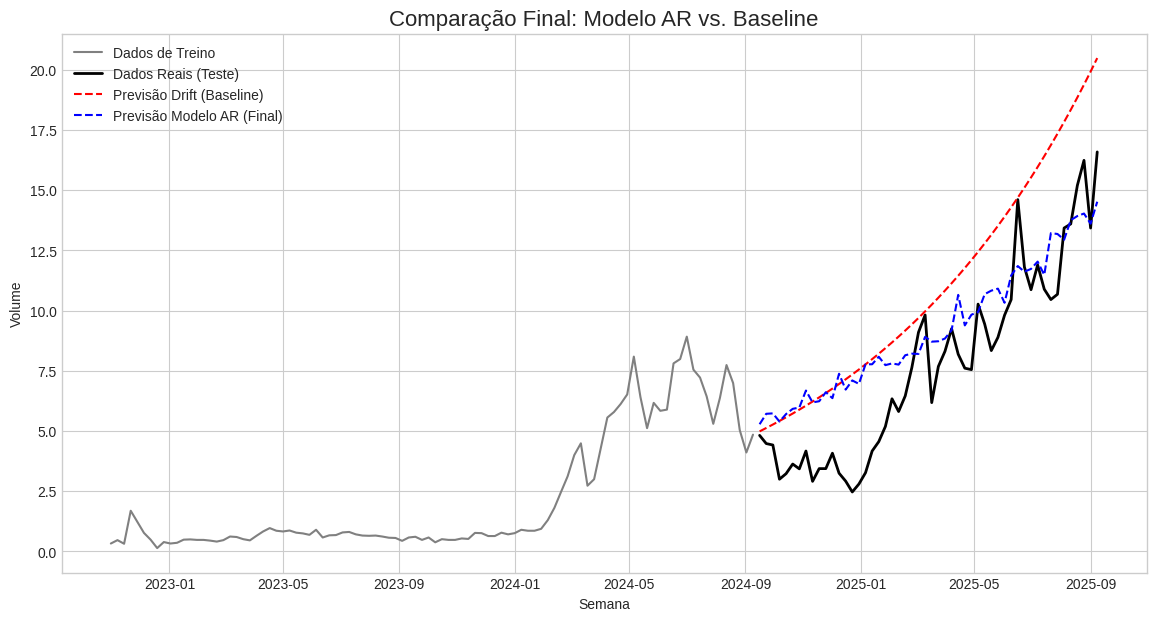

In [15]:
# --- 5.1 Geração de Previsões Iterativas com o Modelo M_AR ---
history_dlog = train['dlog_volume'].dropna().tolist()
predictions_dlog_ar = []

for t in range(len(test)):
    # Lags necessários para a previsão (4 e 5 períodos atrás)
    lag4 = history_dlog[-4]
    lag5 = history_dlog[-5]
    
    # Previsão de 1 passo à frente
    X_pred = [1, lag4, lag5]
    yhat = model_AR.predict(X_pred)[0]
    predictions_dlog_ar.append(yhat)
    
    history_dlog.append(test['dlog_volume'].iloc[t])

# --- 5.2 Reversão das Transformações ---
last_log_volume_train = train['log_volume'].iloc[-1]
pred_log_volume_ar = np.array(predictions_dlog_ar).cumsum() + last_log_volume_train
pred_volume_ar = np.exp(pred_log_volume_ar)

# --- 5.3 Cálculo das Métricas Finais ---
# Calcule o denominador do MASE (erro médio absoluto do modelo naive in-sample)
in_sample_naive_error = train['volume'].diff(1).dropna()
scale_mase = np.mean(np.abs(in_sample_naive_error))

mae_ar = mean_absolute_error(test['volume'], pred_volume_ar)
mase_ar = mae_ar / scale_mase # Reutilizando o fator de escala calculado antes

final_results = {
    'Modelo Drift (Baseline)': calculate_all_metrics(
        y_true=test['volume'], y_pred=predictions_dict['Drift'], train_true=train['volume'],
        mu_log=np.log(predictions_dict['Drift']), sigma_log=np.std(residuals['Drift'])
    ),
    'Modelo AR (Final)': calculate_all_metrics(
        y_true=test['volume'], y_pred=pred_volume_ar, train_true=train['volume'],
        mu_log=pred_log_volume_ar, sigma_log=np.std(residuals_AR)
    )
}
final_results_df = pd.DataFrame(final_results).T

print("--- Tabela de Comparação Final ---")
display(final_results_df)

# --- 5.4 Gráfico Comparativo Final ---
drift_preds = np.exp(drift_model(train['log_volume'], test_size)[0])

fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(train.index[-104:], train['volume'][-104:], label='Dados de Treino', color='gray')
ax.plot(test.index, test['volume'], label='Dados Reais (Teste)', color='black', linewidth=2)
ax.plot(test.index, drift_preds, label='Previsão Drift (Baseline)', color='red', linestyle='--')
ax.plot(test.index, pred_volume_ar, label='Previsão Modelo AR (Final)', color='blue', linestyle='--')
ax.set_title('Comparação Final: Modelo AR vs. Baseline', fontsize=16)
ax.set_xlabel('Semana')
ax.set_ylabel('Volume')
ax.legend()
plt.show()